**Import Libraries**

In [1]:
import os
import copy
import numpy as np
import pandas as pd
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from datetime import datetime

**Load and Preprocess Data**

In [2]:
def load_images_from_folders(data_dir, image_size=(64, 64), limit=None, save_path=None, load_cached=False):
    """
    Loads images from subdirectories where each subdirectory represents a class.
    Saves the processed dataset to a file and loads it from cache if available.
    """
    if load_cached and save_path and os.path.exists(save_path):
        print(f"Loading dataset from cache: {save_path}")
        data = np.load(save_path, allow_pickle=True)
        return data["X"], data["y"]

    all_images = []
    all_labels = []
    class_names = sorted(os.listdir(data_dir))  # Get class folder names
    
    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir):
            continue  # Skip files if any
        
        image_files = os.listdir(class_dir)
        if limit is not None:
            image_files = image_files[:limit]  # Apply limit per class
        
        for image_file in image_files:
            img_path = os.path.join(class_dir, image_file)
            try:
                with Image.open(img_path) as pil_img:
                    pil_img = pil_img.convert('RGB')
                    # pil_img = pil_img.resize(image_size, Image.BILINEAR)
                    img_np = np.array(pil_img)
                    all_images.append(img_np)
                    all_labels.append(class_name)  # Use folder name as label
            except Exception as e:
                print(f"Skipping file {img_path}: {e}")
    
    X = np.array(all_images)
    y = np.array(all_labels)

    # Save the dataset if a save_path is provided
    if save_path:
        np.savez_compressed(save_path, X=X, y=y)
        print(f"Dataset saved to {save_path}")

    return X, y

# Set paths and parameters
data_dir = './removed_bg_dataset'  # The directory containing class subfolders
IMAGE_SIZE = (128, 128)
CACHE_PATH = "dataset_cache.npz"  # Path to save/load dataset

# Load and save data
X, y = load_images_from_folders(data_dir=data_dir, image_size=IMAGE_SIZE, save_path=CACHE_PATH, load_cached=True)

Loading dataset from cache: dataset_cache.npz


**Encode Labels**

In [3]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
class_names = label_encoder.classes_

**Split Data**

In [4]:
# First split into train + (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.4, random_state=42)

# Then split (validation + test) into validation and test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42) 

**Normilize**

In [5]:
# Calculate mean and standard deviation from the training group
train_mean = X_train.mean(axis=(0, 1, 2))
train_std = X_train.std(axis=(0, 1, 2))

# Normalize the training data
X_train_normalized = (X_train - train_mean) / train_std

# Apply the same normalization to the validation and test datasets
X_val_normalized = (X_val - train_mean) / train_std
X_test_normalized = (X_test - train_mean) / train_std

**Prepare Data for PyTorch**

In [6]:
# Transpose axes for PyTorch
X_train = np.transpose(X_train_normalized, (0, 3, 1, 2))
X_val = np.transpose(X_val_normalized, (0, 3, 1, 2))
X_test = np.transpose(X_test_normalized, (0, 3, 1, 2))

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

class ImageDataset(Dataset):
    
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = ImageDataset(X_train_tensor, y_train_tensor)
val_dataset = ImageDataset(X_val_tensor, y_val_tensor)
test_dataset = ImageDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

**Define the Model**

In [7]:
class DogBreedCNN(nn.Module):
    
    def __init__(self, num_classes):
        
        super(DogBreedCNN, self).__init__()

        # Convolutional Block 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout_conv1 = nn.Dropout(p=0.2)

        # Convolutional Block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout_conv2 = nn.Dropout(p=0.2)

        # Convolutional Block 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout_conv3 = nn.Dropout(p=0.2)

        # Fully Connected Layers
        # self.fc1 = nn.Linear(128 * 8 * 8, 256) # (64, 64)
        self.fc1 = nn.Linear(128 * 16 * 16, 256) # (128, 128)
        # self.fc1 = nn.Linear(128 * 28 * 28, 256) # (224, 224)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.dropout_conv1(x)
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.dropout_conv2(x)
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.dropout_conv3(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    

num_classes = len(np.unique(y)) # Number of output classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DogBreedCNN(num_classes).to(device)

**Train The Model**

In [8]:
def train(model, train_loader, val_loader, num_epochs=50, learning_rate=0.01, patience=8, alpha=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.75, patience=3, verbose=True
    )

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    best_val_loss = float('inf')
    best_model_state = None
    no_improve_count = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss_ce = criterion(outputs, labels)

            # L1 regularization
            l1_penalty = torch.tensor(0., requires_grad=True).to(device)
            for name, param in model.named_parameters():
                if "weight" in name and "bn" not in name:  # Exclude biases and BatchNorm parameters
                    l1_penalty += torch.norm(param, p=1)

            # Total loss
            total_loss = loss_ce + alpha * l1_penalty

            total_loss.backward()
            
            optimizer.step()
            
            running_loss += total_loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_accs.append(100. * correct / total)

        model.eval()
        val_loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss_ce = criterion(outputs, labels)

                # L1 regularization in validation
                l1_penalty = torch.tensor(0., requires_grad=False).to(device)
                for name, param in model.named_parameters():
                    if "weight" in name and "bn" not in name:  # Exclude biases and BatchNorm parameters
                        l1_penalty += torch.norm(param, p=1)

                total_loss = loss_ce + alpha * l1_penalty
                val_loss += total_loss.item()

                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accs.append(100. * correct / total)
        
        # Learning rate scheduling
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.2f}%")

        # Early stopping mechanism
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            best_model_state = copy.deepcopy(model.state_dict())
            no_improve_count = 0
        else:
            no_improve_count += 1

        if no_improve_count >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    # Restore the best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return train_losses, val_losses, train_accs, val_accs

num_of_epochs = 100
lr = 0.0005
train_losses, val_losses, train_accs, val_accs = train(model, train_loader, val_loader, num_epochs=num_of_epochs, learning_rate=lr)

Epoch 1/100, Train Loss: 7.2992, Train Acc: 16.22%
Epoch 2/100, Train Loss: 3.9960, Train Acc: 20.23%
Epoch 3/100, Train Loss: 3.6400, Train Acc: 23.44%
Epoch 4/100, Train Loss: 3.2873, Train Acc: 25.66%
Epoch 5/100, Train Loss: 3.0687, Train Acc: 28.40%
Epoch 6/100, Train Loss: 2.9093, Train Acc: 30.04%
Epoch 7/100, Train Loss: 2.8122, Train Acc: 31.60%
Epoch 8/100, Train Loss: 2.7288, Train Acc: 33.21%
Epoch 9/100, Train Loss: 2.6938, Train Acc: 33.99%
Epoch 10/100, Train Loss: 2.7066, Train Acc: 35.05%
Epoch 11/100, Train Loss: 2.6635, Train Acc: 36.73%
Epoch 12/100, Train Loss: 2.6668, Train Acc: 37.51%
Epoch 13/100, Train Loss: 2.6640, Train Acc: 38.92%
Epoch 00014: reducing learning rate of group 0 to 3.7500e-04.
Epoch 14/100, Train Loss: 2.6533, Train Acc: 39.98%
Epoch 15/100, Train Loss: 2.4022, Train Acc: 42.00%
Epoch 16/100, Train Loss: 2.3939, Train Acc: 43.12%
Epoch 17/100, Train Loss: 2.3254, Train Acc: 44.58%
Epoch 18/100, Train Loss: 2.2828, Train Acc: 44.79%
Epoch 19/10

**Evaluate The Model**

In [9]:
def evaluate(model, loader):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

# Evaluate on train set
y_train_true, y_train_pred = evaluate(model, train_loader)

# Evaluate on test set
y_test_true, y_test_pred = evaluate(model, test_loader)

# Compute evaluation metrics
accuracy_train = accuracy_score(y_train_true, y_train_pred)
accuracy_test = accuracy_score(y_test_true, y_test_pred)
f1_test = f1_score(y_test, y_test_pred, average='weighted')
report = classification_report(y_test, y_test_pred, target_names=label_encoder.classes_, zero_division=0)

print(f'Training Accuracy: {accuracy_train:.3f}')
print(f'Test Accuracy: {accuracy_test:.3f}')
print(f'F1 Score: {f1_test:.3f}')
print("Classification Report:")
print(report)

# Log current evaluation details
current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
details = (
    f"Training Accuracy: {accuracy_train:.3f}\n"
    f"Test Accuracy: {accuracy_test:.3f}\n"
    f"F1 Score: {f1_test:.3f}\n"
    f"Image Size: {IMAGE_SIZE}\n"
    f"Num of Epochs: {num_of_epochs}\n"
    f"Learning Rate: {lr}\n"
)

output_file = "CNN_results_rbg.txt"

# Save the results to the output file
with open(output_file, 'a') as f:
    f.write(f"Report generated at: {current_time}\n")
    f.write(details + "\n")
    f.write(report + "\n\n")

Training Accuracy: 0.729
Test Accuracy: 0.581
F1 Score: 0.580
Classification Report:
                    precision    recall  f1-score   support

            beagle       0.70      0.67      0.69       613
             boxer       0.68      0.56      0.61       587
         chihuahua       0.58      0.46      0.51       636
            collie       0.47      0.60      0.52       621
          doberman       0.82      0.82      0.82       604
  golden_retriever       0.53      0.42      0.47       573
labrador_retriever       0.44      0.39      0.41       568
        pomeranian       0.68      0.67      0.68       596
            poodle       0.50      0.64      0.57       644
            shitzu       0.48      0.57      0.52       558

          accuracy                           0.58      6000
         macro avg       0.59      0.58      0.58      6000
      weighted avg       0.59      0.58      0.58      6000



Predicted Breed: poodle


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


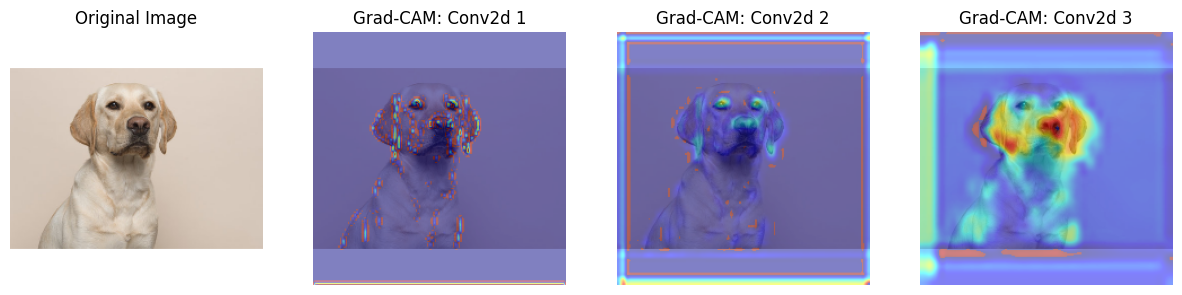

In [10]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Hook to get gradients and activations
        self.target_layer.register_forward_hook(self._save_activations)
        self.target_layer.register_backward_hook(self._save_gradients)

    def _save_activations(self, module, input, output):
        self.activations = output

    def _save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self, input_tensor, class_idx=None):
        # Forward pass
        input_tensor = input_tensor.to(next(self.model.parameters()).device)  # Move input to model's device
        output = self.model(input_tensor)  # Forward pass
        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()

        # Compute gradients for the predicted class
        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0][class_idx] = 1
        output.backward(gradient=one_hot)

        # Compute Grad-CAM heatmap
        grads = self.gradients.cpu().data.numpy()
        activations = self.activations.cpu().data.numpy()
        weights = np.mean(grads, axis=(2, 3))  # Global Average Pooling over spatial dimensions
        cam = np.sum(weights[:, :, None, None] * activations, axis=1)
        cam = np.maximum(cam, 0)  # ReLU to remove negative values

        # Normalize heatmap
        cam = cam[0]
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        return cam

# Load an example image
def preprocess_image(img_path, image_size=128):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    img = cv2.imread(img_path)
    img = cv2.resize(img, (image_size, image_size)) / 255.0  # Normalize
    img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)  # Convert to PyTorch format
    img = img.to(device)  # Move image to GPU if available
    
    return img


# Overlay Grad-CAM on the original image
def overlay_heatmap(img_path, heatmaps, conv_layers, alpha=0.5):
    """ Generates and displays Grad-CAM heatmaps for all convolutional layers. """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    # Load and preprocess image
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    original_size = img_rgb.shape[:2]  # Get (height, width)

    # Resize heatmaps to match original image size
    resized_heatmaps = [
        cv2.resize(heatmap, original_size[::-1], interpolation=cv2.INTER_CUBIC) for heatmap in heatmaps
    ]

    # Plot original + all Grad-CAM layers
    num_layers = len(conv_layers)
    fig, axes = plt.subplots(1, num_layers + 1, figsize=(15, 5))

    # Plot original image
    axes[0].imshow(img_rgb)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Plot Grad-CAM heatmaps for each layer
    for i, (layer, heatmap) in enumerate(zip(conv_layers, resized_heatmaps)):
        heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
        overlay = cv2.addWeighted(img_rgb, alpha, heatmap_colored, 1 - alpha, 0)

        axes[i + 1].imshow(overlay)
        axes[i + 1].set_title(f"Grad-CAM: {layer.__class__.__name__} {i+1}")
        axes[i + 1].axis("off")

    plt.show()


    
def predict_image(model, img_path, class_names):
    """ Runs inference on a single image and returns the predicted class. """
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Preprocess image
    input_tensor = preprocess_image(img_path)

    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = output.max(1)

    predicted_class = class_names[predicted.item()]
    return predicted_class


# Select the last convolutional layer for Grad-CAM
target_layer = model.conv3  # The last conv layer in DogBreedCNN

# Initialize Grad-CAM
grad_cam = GradCAM(model, target_layer)

# Load and preprocess an image
img_path = "./dataset/labrador_retriever/labrador_retriever_609.png"  # Provide an example image path
input_tensor = preprocess_image(img_path)

predicted_label = predict_image(model, img_path, class_names)
print(f"Predicted Breed: {predicted_label}")

# Generate Grad-CAM heatmaps for all conv layers
conv_layers = [model.conv1, model.conv2, model.conv3]
heatmaps = [GradCAM(model, layer).generate(input_tensor) for layer in conv_layers]

# Overlay heatmaps on original image
overlay_heatmap(img_path, heatmaps, conv_layers)
